This file...  
...handles feature scaling (using *StandardScaler()*),  
...model training, testing (using *CatBoostClassifier*),  
...validation, and evaluation (using *CalibratedClassifierCV*).

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

In [ ]:
# X = pd.read_pickle('../testing/X_clean.pkl')
# Y = pd.read_pickle('../testing/Y_clean.pkl')
X = pd.read_pickle('data/X.pkl')
Y = pd.read_pickle('data/Y.pkl')

In [99]:
y_score = Y['scores']
y_concede = Y['concedes']

In [103]:
continuous_cols = [
    'time', 'start_x_ai', 'start_z_ai', 'end_x_ai', 'end_z_ai',
    'start_dist_to_goal_ai', 'start_angle_to_angle_ai',
    'end_dist_to_goal_ai', 'end_angle_to_angle_ai', 'movement_ai', 
    'goalscore_diff', 'speed', 'time_delta_i', 'dx_a0i', 'dy_a0i', 'mov_a0i',
    'defensive_density'
]
# Generate _prev1, _prev2, _prev3 variants
prev_cols = [f"{col}_prev{i}" for col in continuous_cols for i in range(1, 4)]

# Combine all
all_continuous_cols = continuous_cols + prev_cols

In [105]:
scaler = StandardScaler()
X[all_continuous_cols] = scaler.fit_transform(X[all_continuous_cols])

In [106]:
X_train, X_test, y_score_train, y_score_test = train_test_split(
    X, y_score, test_size=0.2, random_state=42)

_, _, y_concede_train, y_concede_test = train_test_split(
    X, y_concede, test_size=0.2, random_state=42)

In [107]:
# Evaluation metric: use AUC
scorer = make_scorer(brier_score_loss, needs_proba=True)

# Cross-validation scheme
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for best models
best_models = {}

c:\Users\CasGerritsen\miniconda3\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


In [108]:
Y_hat = pd.DataFrame()
models = {}

# Loop through each target column in Y
for col in Y.columns:
    print(f"Tuning model for: {col}")
    
    # Calculate class weights
    num_negative = (Y[col] == 0).sum()
    num_positive = (Y[col] == 1).sum()
    
    if num_positive == 0:
        class_weights = [1.0, 1.0]  # fallback
    else:
        scale = num_negative / num_positive
        class_weights = [1.0, scale]  # [class 0 weight, class 1 weight]

    # Define the CatBoost model
    model = CatBoostClassifier(
        allow_writing_files=False,
        verbose=0,
        thread_count=-1,
        class_weights=class_weights,
        eval_metric='AUC',
        loss_function='Logloss',
        random_state=42
    )

    # Define the parameter grid
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'rsm': [0.8, 0.9, 1.0],  # Equivalent to colsample_bytree
        # 'subsample': [0.8, 0.9, 1.0], 
    }

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=make_scorer(brier_score_loss, greater_is_better=False),
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    # Fit the model
    grid_search.fit(X, Y[col])

    # Store best model
    models[col] = grid_search.best_estimator_

    print(f"Best parameters for {col}: {grid_search.best_params_}")

    # Store predictions (optional)
    Y_hat[col] = grid_search.predict(X)

Tuning model for: scores
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for scores: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'rsm': 0.9}
Tuning model for: concedes
Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters for concedes: {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 200, 'rsm': 0.9}


In [109]:
# print(grid_search.best_params_)
test_params = {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'rsm': 0.9}

### Cross-validation for target: scores ###
Evaluation Metrics for: scores

Brier Score:
  Uncalibrated: 0.11025
  Isotonic-Calibrated: 0.01849
  Baseline: 0.02700

Log Loss:
  Uncalibrated: 0.36865
  Isotonic-Calibrated: 0.08836
  Baseline: 0.12690

ROC AUC:
  Uncalibrated: 0.78690
  Isotonic-Calibrated: 0.80446
  Baseline: 0.50000


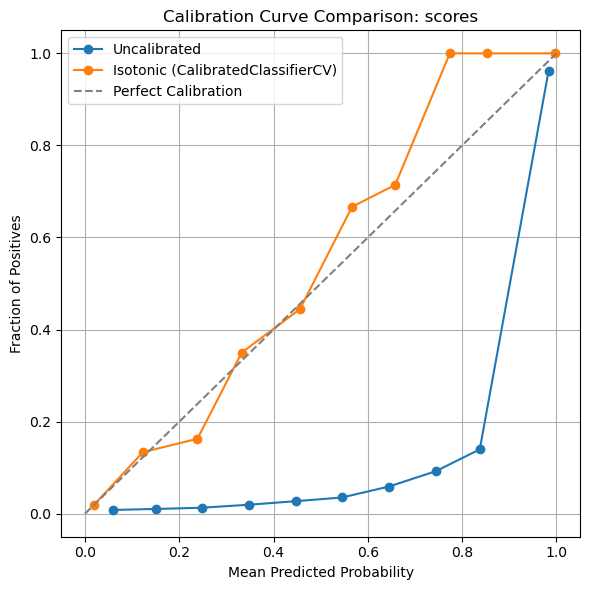

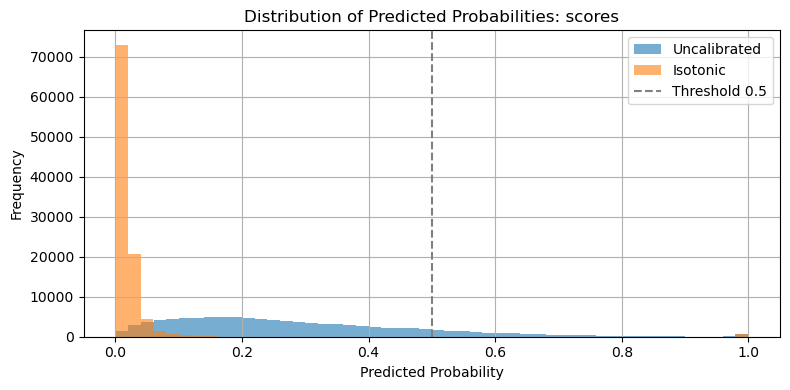

### Cross-validation for target: concedes ###
Evaluation Metrics for: concedes

Brier Score:
  Uncalibrated: 0.05275
  Isotonic-Calibrated: 0.00542
  Baseline: 0.00543

Log Loss:
  Uncalibrated: 0.19762
  Isotonic-Calibrated: 0.03308
  Baseline: 0.03387

ROC AUC:
  Uncalibrated: 0.60432
  Isotonic-Calibrated: 0.64663
  Baseline: 0.50000


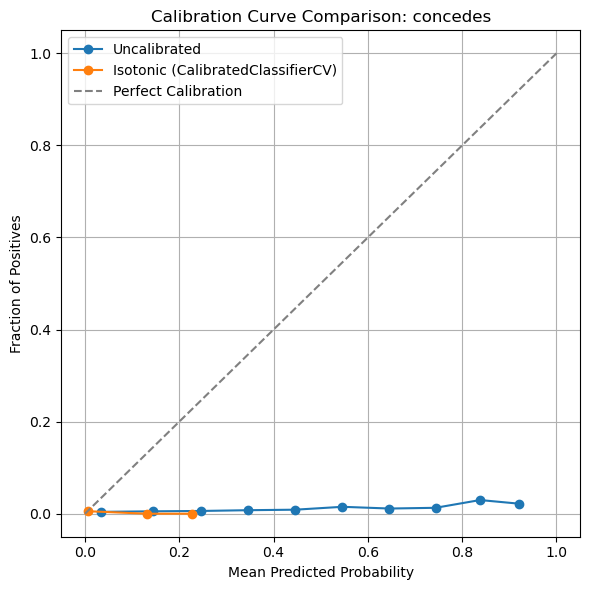

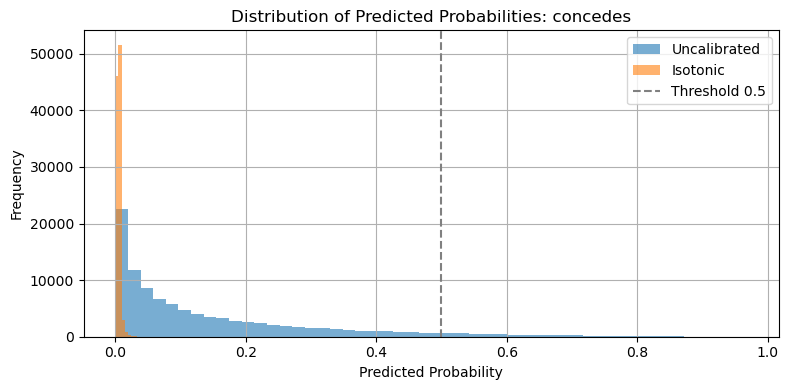

In [110]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for col in Y.columns:
    print(f"### Cross-validation for target: {col} ###")
    
    y = Y[col].values  # Get labels for this target

    # Storage for predictions
    y_probs_uncalibrated = []
    y_probs_isotonic = []
    y_trues = []

    for train_idx, test_idx in kf.split(X, y):
        X_fold_trainval, X_fold_test = X.iloc[train_idx], X.iloc[test_idx]
        y_fold_trainval, y_fold_test = y[train_idx], y[test_idx]

        # Split training into model-training and calibration
        X_fold_train, X_fold_calib, y_fold_train, y_fold_calib = train_test_split(
            X_fold_trainval, y_fold_trainval, test_size=0.2, random_state=42, stratify=y_fold_trainval
        )
        
        # Clone best model
        base_model = models[col]
        
        # Clone base model parameters
        params = base_model.get_params()

        # Manually override specific parameters
        params.update({
            'learning_rate': 0.2,
            'max_depth': 5,
            'n_estimators': 100,
            'rsm': 0.9
        })

        # model = CatBoostClassifier(**base_model.get_params())
        model = CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)

        # Uncalibrated
        proba_uncal = model.predict_proba(X_fold_test)[:, 1]
        y_probs_uncalibrated.extend(proba_uncal)

        # # Isotonic Calibration (built-in)
        isotonic_model = CalibratedClassifierCV(
            # estimator=CatBoostClassifier(**base_model.get_params()),
            estimator=CatBoostClassifier(**params),
            method='isotonic',
            cv=5
        )
        isotonic_model.fit(X_fold_trainval, y_fold_trainval)
        proba_isotonic = isotonic_model.predict_proba(X_fold_test)[:, 1]
        y_probs_isotonic.extend(proba_isotonic)

        y_trues.extend(y_fold_test)
        
    print(f"Evaluation Metrics for: {col}")

    # Baseline: constant predicted probability equal to class prevalence
    baseline = [np.mean(y_trues)] * len(y_trues)

    # --- Brier Score ---
    print("\nBrier Score:")
    print(f"  Uncalibrated: {brier_score_loss(y_trues, y_probs_uncalibrated):.5f}")
    print(f"  Isotonic-Calibrated: {brier_score_loss(y_trues, y_probs_isotonic):.5f}")
    print(f"  Baseline: {brier_score_loss(y_trues, baseline):.5f}")

    # --- Log Loss ---
    print("\nLog Loss:")
    print(f"  Uncalibrated: {log_loss(y_trues, y_probs_uncalibrated):.5f}")
    print(f"  Isotonic-Calibrated: {log_loss(y_trues, y_probs_isotonic):.5f}")
    print(f"  Baseline: {log_loss(y_trues, baseline):.5f}")

    # --- ROC AUC ---
    print("\nROC AUC:")
    print(f"  Uncalibrated: {roc_auc_score(y_trues, y_probs_uncalibrated):.5f}")
    print(f"  Isotonic-Calibrated: {roc_auc_score(y_trues, y_probs_isotonic):.5f}")
    print(f"  Baseline: {roc_auc_score(y_trues, baseline):.5f}")

    # Plot calibration curves for this target
    prob_true_uncal, prob_pred_uncal = calibration_curve(y_trues, y_probs_uncalibrated, n_bins=10)
    prob_true_isotonic, prob_pred_isotonic = calibration_curve(y_trues, y_probs_isotonic, n_bins=10)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred_uncal, prob_true_uncal, marker='o', label='Uncalibrated')
    plt.plot(prob_pred_isotonic, prob_true_isotonic, marker='o', label='Isotonic (CalibratedClassifierCV)')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.title(f'Calibration Curve Comparison: {col}')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Now plot the distribution for this target
    plt.figure(figsize=(8, 4))
    plt.hist(y_probs_uncalibrated, bins=50, alpha=0.6, label='Uncalibrated')
    plt.hist(y_probs_isotonic,   bins=50, alpha=0.6, label='Isotonic')
    plt.axvline(0.5, color='gray', linestyle='--', label='Threshold 0.5')
    plt.legend()
    plt.title(f'Distribution of Predicted Probabilities: {col}')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [112]:
for col in Y.columns:
    base_model = models[col]  # Your base CatBoost model with tuned params
    base_model.fit(X, Y[col])  # Fit on full data

    calibrated_model = CalibratedClassifierCV(
        estimator=base_model,
        method='isotonic',
        cv=5
    )
    calibrated_model.fit(X, Y[col])  # Calibrate on the same full data

    # Store the calibrated model
    models[col] = calibrated_model

In [ ]:
joblib.dump(models, "data/models.pkl")
joblib.dump(scaler, "data/scaler.pkl")

['scaler.pkl']

The code below can be used to check how different actions are valued by VAEP. I looked for indexes with goals and compared these with the actual play. For the indexes, I used *testing/eval_cat_2.ipynb*, but the code to filter these goals was:  
game_id = <some_number>  
filtered_df = vaep_df[vaep_df['game_id'] == game_id]  
filtered_df = filtered_df[filtered_df['actiontype_eventshot'] == 1]  
successful_actions_id = filtered_df[filtered_df['actionresult_success'] == 1]  

vaep_df can be replaced  
later on a new X is made called *test_X*, where the values are scaled back to visualize the actions.

In [114]:
def plot_action_with_history(X, index, history=3, image_path="../hockey_rink.png"):
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    # Load the pitch image
    img = mpimg.imread(image_path)

    # Team color map (0 = green, 1 = purple)
    team_colors = {0: 'green', 1: 'purple'}

    # Set up plot
    plt.figure(figsize=(12, 7))
    plt.title("Action Trajectory")
    plt.imshow(img, extent=[-35.5, 35.5, -18, 18], aspect='auto')

    # Indices of actions: current + history steps before
    indices_to_plot = list(range(max(0, index - history), index + 1))
    alphas = [0.3 + 0.7 * (i / (len(indices_to_plot) - 1)) for i in range(len(indices_to_plot))]

    for i, (row_idx, alpha) in enumerate(zip(indices_to_plot, alphas)):
        row = X.loc[row_idx]
        sx, sz = row["start_x_ai"], row["start_z_ai"]
        ex, ez = row["end_x_ai"], row["end_z_ai"]
        team = row["team"]
        time = row["time"]

        # Determine action type
        if row.get("actiontype_eventpass", 0) == 1:
            action_type = "pass"
        elif row.get("actiontype_eventshot", 0) == 1:
            action_type = "shot"
        elif row.get("actiontype_eventturnover", 0) == 1:
            action_type = "turnover"
        else:
            action_type = "unknown"

        label_text = f"{action_type} ({int(time)})"
        color = team_colors.get(team, 'gray')

        label = "current" if row_idx == index else f"step-{index - row_idx}"

        print(f"{label}: {label_text} | start=({sx}, {sz}), end=({ex}, {ez}), dx={ex - sx}, dz={ez - sz}")

        plt.arrow(sx, sz, ex - sx, ez - sz,
                  color=color, alpha=alpha, head_width=0.5, length_includes_head=True)
        plt.scatter(sx, sz, color=color, alpha=alpha)
        plt.text(sx + 0.5, sz + 0.5, label_text, fontsize=9, color=color, alpha=alpha)

    # Pitch dimensions and visuals
    plt.xlim(-35, 35)
    plt.ylim(-15, 15)
    plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
    plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(False)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [115]:
filtered_df = X[X['actiontype_eventshot'] == 1]
successful_actions = filtered_df[filtered_df['actionresult_success'] == 1]
successful_indices_list = successful_actions.index.tolist()
random_index = random.choice(successful_indices_list)

In [116]:
# Inverse transform the continuous columns
scaledbackcontinuous = pd.DataFrame(
    scaler.inverse_transform(X[all_continuous_cols]),
    columns=all_continuous_cols,
    index=X.index
)

# Extract the remaining (non-scaled) columns from X
othercolumns = X.drop(columns=all_continuous_cols)

# Combine them together
test_X = pd.concat([scaledbackcontinuous, othercolumns], axis=1)

In [117]:
index = 16113
index = index + 4

step-2: pass (422) | start=(16.9182, 8.4117), end=(10.6127, -3.2259), dx=-6.3054999999999986, dz=-11.637599999999999
step-1: pass (424) | start=(10.0986, -9.4123), end=(18.5824, 7.2044), dx=8.4838, dz=16.6167
current: shot (425) | start=(22.869, 0.12680000000000002), end=(26.95, 0.0), dx=4.0809999999999995, dz=-0.12680000000000002


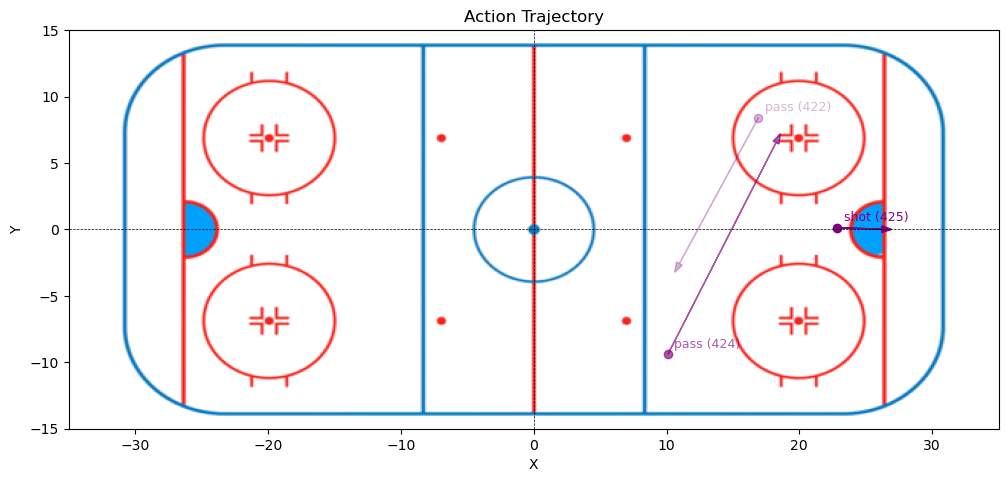

In [118]:
plot_action_with_history(test_X, index, 2)

In [119]:
for i in range((index-8), (index-2)):  # start from one after the first action
    action_prev = X.iloc[[i - 1]]
    action_curr = X.iloc[[i]]
    
    # Predict probabilities before and after the current action
    prob_score_before = models["scores"].predict_proba(action_prev)[0][1]
    prob_score_after = models["scores"].predict_proba(action_curr)[0][1]

    prob_concede_before = models["concedes"].predict_proba(action_prev)[0][1]
    prob_concede_after = models["concedes"].predict_proba(action_curr)[0][1]
    
    # VAEP calculation
    vaep = (prob_score_after - prob_score_before) - (prob_concede_after - prob_concede_before)
    
    # print(f"Action {i} (start_x: {action_curr["start_x_ai"]})")
    # print(f"Score Before: {prob_score_before:.4f}, After: {prob_score_after:.4f}")
    print(f"ΔP_Score: {prob_score_after - prob_score_before}")
    # print(f"Concede Before: {prob_concede_before:.4f}, After: {prob_concede_after:.4f}")
    print(f"ΔP_Concede: {prob_concede_after - prob_concede_before}")
    print(f"VAEP = {vaep:.4f}")
    print("   ")

ΔP_Score: -0.00593066574586866
ΔP_Concede: 0.0005098450746264622
VAEP = -0.0064
   
ΔP_Score: -0.005244506948548805
ΔP_Concede: -0.00021749763766165317
VAEP = -0.0050
   
ΔP_Score: 0.4398188346343394
ΔP_Concede: -0.001494047539396988
VAEP = 0.4413
   
ΔP_Score: 0.04310535067195326
ΔP_Concede: 0.001201700102432179
VAEP = 0.0419
   
ΔP_Score: 0.07031999774696374
ΔP_Concede: 0.0007329754004079527
VAEP = 0.0696
   
ΔP_Score: 0.4285095570896681
ΔP_Concede: -0.000511084368567275
VAEP = 0.4290
   


In [ ]:
# Inverse transform the continuous columns
scaled_back_continuous = pd.DataFrame(
    scaler.inverse_transform(X[all_continuous_cols]),
    columns=all_continuous_cols,
    index=X.index
)

# Extract the remaining (non-scaled) columns from X
other_columns = X.drop(columns=all_continuous_cols)

# Combine them together
new_x = pd.concat([scaled_back_continuous, other_columns], axis=1)

In the code below, vaep_df is created, where the first 50.000 actions are valued and written down to 'vaep_df.pkl', so I did not have to run it each time again when evaluating. vaep_df is used for plotting average values against some features.

In [ ]:
vaep_results = []
n = 50000

columns_to_copy = [
    'period', 'actiontype_eventpass', 'actiontype_eventshot',
    'actiontype_eventturnover', 'actionresult_success',
    'actionresult_miss', 'time', 'team', 'start_x_ai', 'start_z_ai', 
    'end_x_ai', 'end_z_ai', 'start_dist_to_goal_ai', 'start_angle_to_angle_ai',
    'end_dist_to_goal_ai', 'end_angle_to_angle_ai', 'movement_ai', 
    'goalscore_diff', 'strength_difference', 'time_delta_i', 'dx_a0i', 'defensive_density',
    'dy_a0i', 'mov_a0i'
]

for i in range(1, n):
    try:
        action_prev = X.iloc[[i - 1]]
        action_curr = X.iloc[[i]]

        prob_score_before = models["scores"].predict_proba(action_prev)[0][1]
        prob_score_after = models["scores"].predict_proba(action_curr)[0][1]
        delta_scoring = prob_score_after - prob_score_before

        prob_concede_before = models["concedes"].predict_proba(action_prev)[0][1]
        prob_concede_after = models["concedes"].predict_proba(action_curr)[0][1]
        delta_conceding = prob_concede_after - prob_concede_before

        vaep = delta_scoring - delta_conceding

        row = {col: new_x.iloc[i][col] for col in columns_to_copy}
        row.update({
            'index': i,
            'prob_score_before': prob_score_before,
            'prob_score_after': prob_score_after,
            'delta_scoring': delta_scoring,
            'prob_concede_before': prob_concede_before,
            'prob_concede_after': prob_concede_after,
            'delta_conceding': delta_conceding,
            'vaep': vaep
        })

        vaep_results.append(row)

    except Exception as e:
        print(f"Skipping index {i} due to error: {e}")

In [ ]:
vaep_df = pd.DataFrame(vaep_results)

In [ ]:
df = pd.read_csv('../../processed_data/all_actions_4.0.csv')
df = df[3:]
df = df.reset_index(drop=True)

In [ ]:
new_x = new_x.reset_index(drop=True)

In [ ]:
new_x['game_id'] = df['game_id']
new_x['timestamp'] = df['timestamp']

In [ ]:
vaep_df['TimestampUTC'] = df['timestamp'].iloc[:len(vaep_df)].values
new_x['TimestampUTC'] = df['timestamp'].iloc[:len(new_x)].values

In [ ]:
vaep_df.to_pickle('data/vaep_df.pkl')

In [ ]:
startcorrelation_score = vaep_df['start_x_ai'].corr(vaep_df['prob_score_after'])
startcorrelation_concede = vaep_df['start_x_ai'].corr(vaep_df['prob_concede_after'])
print(f"Correlation between start_x_ai and delta_scoring: {startcorrelation_score:.4f}")
print(f"Correlation between start_x_ai and delta_scoring: {startcorrelation_concede:.4f}")
endcorrelation_score = vaep_df['end_x_ai'].corr(vaep_df['prob_score_after'])
endcorrelation_concede = vaep_df['end_x_ai'].corr(vaep_df['prob_concede_after'])
print(f"Correlation between end_x_ai and delta_scoring: {endcorrelation_score:.4f}")
print(f"Correlation between end_x_ai and delta_scoring: {endcorrelation_concede:.4f}")

Correlation between start_x_ai and delta_scoring: 0.1409
Correlation between start_x_ai and delta_scoring: -0.0229
Correlation between end_x_ai and delta_scoring: 0.1760
Correlation between end_x_ai and delta_scoring: -0.0428


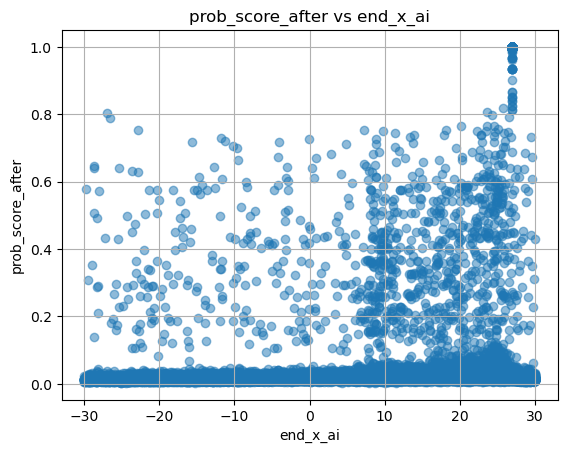

In [ ]:
plt.scatter(vaep_df['end_x_ai'], vaep_df['prob_score_after'], alpha=0.5)
plt.xlabel('end_x_ai')
plt.ylabel('prob_score_after')
plt.title('prob_score_after vs end_x_ai')
plt.grid(True)
plt.show()

In [ ]:
# Define the ranges
ranges = [(-30, -10), (-10, 10), (10, 30)]

# Loop through each range and compute the mean
for lower, upper in ranges:
    group = vaep_df[(vaep_df['end_x_ai'] > lower) & (vaep_df['end_x_ai'] <= upper)]
    mean_value = group['prob_score_after'].mean()
    print(f"Average prob_score_after for end_x_ai in [{lower}, {upper}]: {mean_value:.4f}")

Average prob_score_after for end_x_ai in [-30, -10]: 0.0180
Average prob_score_after for end_x_ai in [-10, 10]: 0.0243
Average prob_score_after for end_x_ai in [10, 30]: 0.0555


In [ ]:
# Filter indices to be within the bounds of vaep_df
filtered_indices = [i for i in successful_indices_list if i < 5000]

# Now get the relevant rows from vaep_df
goal_vaep_df = vaep_df.loc[filtered_indices]

# Extract start_x_ai and prob_score_before
goal_summary_df = pd.DataFrame({
    'start_x_ai': goal_vaep_df['start_x_ai'],
    'prob_score_before': goal_vaep_df['prob_score_before']
})

print(goal_summary_df['prob_score_before'].mean())

0.03331304891555602


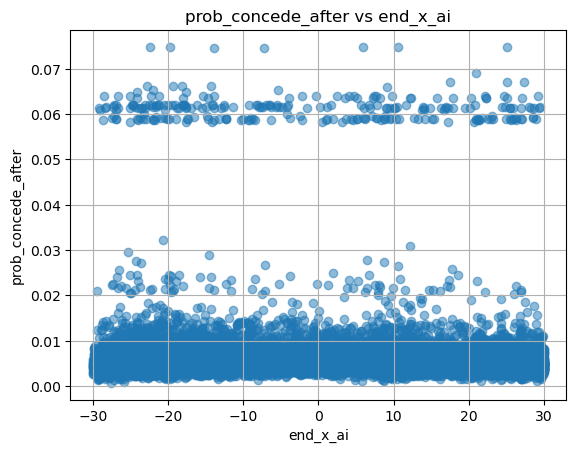

In [ ]:
plt.scatter(vaep_df['end_x_ai'], vaep_df['prob_concede_after'], alpha=0.5)
plt.xlabel('end_x_ai')
plt.ylabel('prob_concede_after')
plt.title('prob_concede_after vs end_x_ai')
plt.grid(True)
plt.show()

In [ ]:
# Define the ranges
ranges = [(-30, -10), (-10, 10), (10, 30)]

# Loop through each range and compute the mean
for lower, upper in ranges:
    group = vaep_df[(vaep_df['end_x_ai'] > lower) & (vaep_df['end_x_ai'] <= upper)]
    mean_value = group['prob_concede_after'].mean()
    print(f"Average prob_concede_after for end_x_ai in [{lower}, {upper}]: {mean_value:.4f}")

Average prob_concede_after for end_x_ai in [-30, -10]: 0.0057
Average prob_concede_after for end_x_ai in [-10, 10]: 0.0057
Average prob_concede_after for end_x_ai in [10, 30]: 0.0053


In [ ]:
print(f"Min X: {vaep_df['start_x_ai'].min()}, Max X: {vaep_df['start_x_ai'].max()}")

Min X: -29.98, Max X: 29.98


C:\Users\CasGerritsen\AppData\Local\Temp\ipykernel_11528\3252144070.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = vaep_df.groupby('x_bin')[['prob_score_before', 'prob_concede_before']].mean()


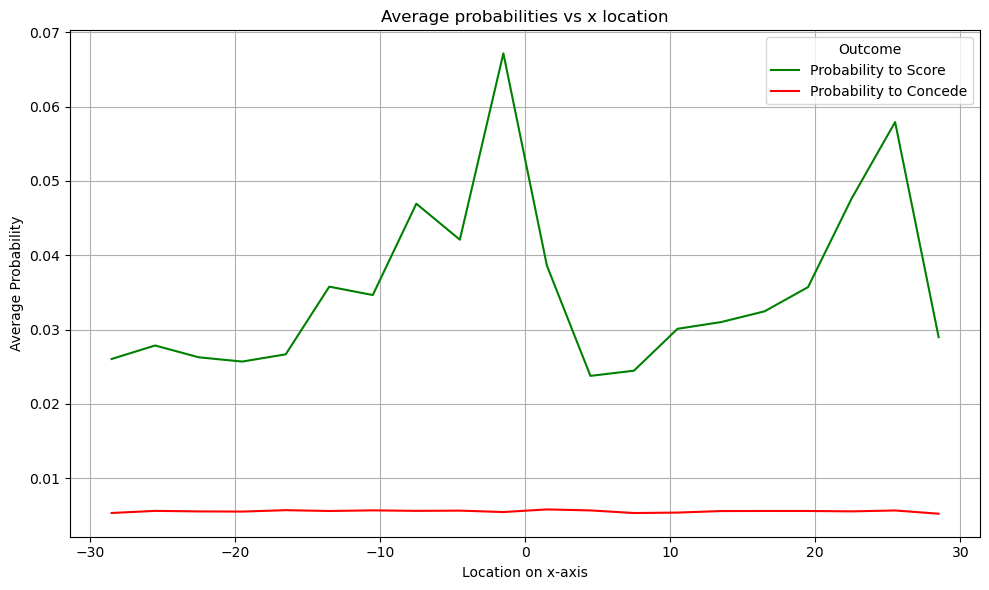

In [ ]:
# Define bins and compute binned means
vaep_df['x_bin'] = pd.cut(vaep_df['start_x_ai'], bins=np.linspace(-30, 30, 21))  # 20 bins

binned_means = vaep_df.groupby('x_bin')[['prob_score_before', 'prob_concede_before']].mean()
binned_centers = [interval.mid for interval in binned_means.index]

plt.figure(figsize=(10, 6))
plt.plot(binned_centers, binned_means['prob_score_before'], label='Probability to Score', color='green')
plt.plot(binned_centers, binned_means['prob_concede_before'], label='Probability to Concede', color='red')

plt.xlabel('Location on x-axis')
plt.ylabel('Average Probability')
plt.title('Average probabilities vs x location')
plt.legend(title='Outcome')
plt.grid(True)
plt.tight_layout()
plt.show()

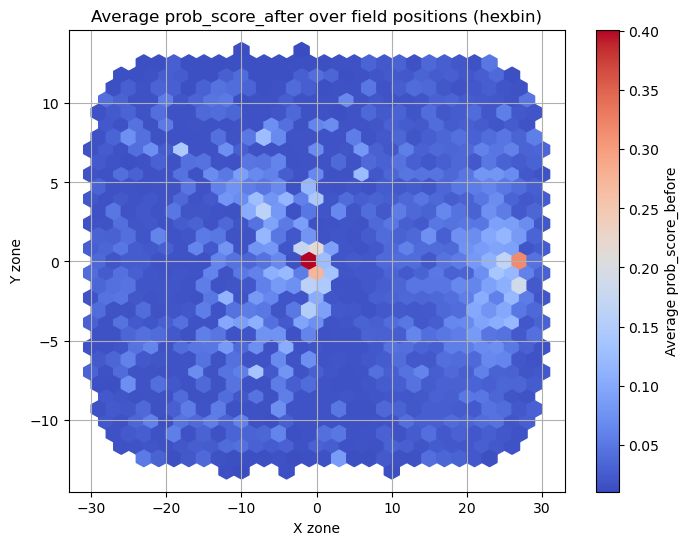

In [ ]:
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    vaep_df['start_x_ai'], 
    vaep_df['start_z_ai'], 
    C=vaep_df['prob_score_before'],
    gridsize=30,  # Adjust resolution
    reduce_C_function=np.mean,
    cmap='coolwarm'
)
plt.xlabel('X zone')
plt.ylabel('Y zone')
plt.title('Average prob_score_after over field positions (hexbin)')
plt.colorbar(hb, label='Average prob_score_before')
plt.grid(True)
plt.show()

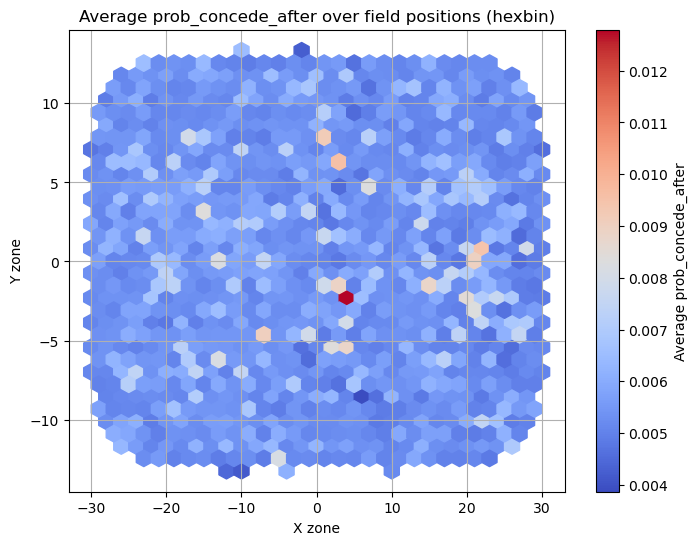

In [ ]:
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    vaep_df['start_x_ai'], 
    vaep_df['start_z_ai'], 
    C=vaep_df['prob_concede_before'],
    gridsize=30,  # Adjust resolution
    reduce_C_function=np.mean,
    cmap='coolwarm'
)
plt.xlabel('X zone')
plt.ylabel('Y zone')
plt.title('Average prob_concede_after over field positions (hexbin)')
plt.colorbar(hb, label='Average prob_concede_after')
plt.grid(True)
plt.show()

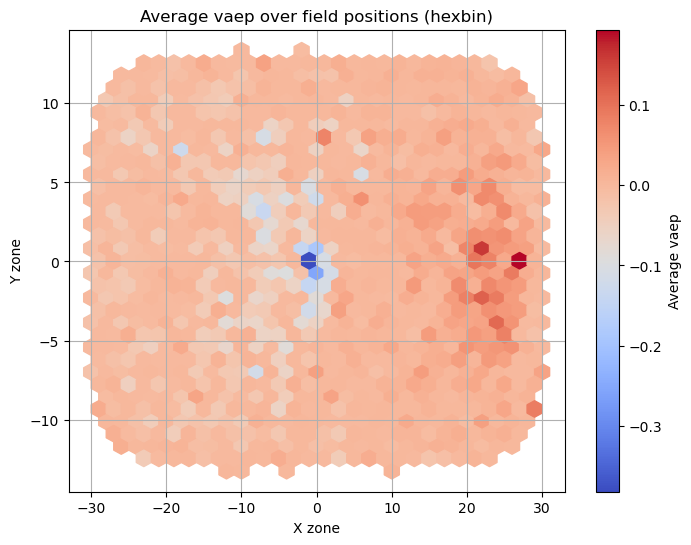

In [ ]:
plt.figure(figsize=(8, 6))
hb = plt.hexbin(
    vaep_df['start_x_ai'], 
    vaep_df['start_z_ai'], 
    C=vaep_df['vaep'],
    gridsize=30,  # Adjust resolution
    reduce_C_function=np.mean,
    cmap='coolwarm'
)
plt.xlabel('X zone')
plt.ylabel('Y zone')
plt.title('Average vaep over field positions (hexbin)')
plt.colorbar(hb, label='Average vaep')
plt.grid(True)
plt.show()

In [ ]:
# Define the ranges
ranges = [(-30, -10), (-10, 10), (10, 30)]

# Loop through each range and compute the mean
for lower, upper in ranges:
    group = vaep_df[(vaep_df['end_x_ai'] > lower) & (vaep_df['end_x_ai'] <= upper)]
    mean_value = group['vaep'].mean()
    print(f"Average vaep for end_x_ai in [{lower}, {upper}]: {mean_value:.4f}")

Average vaep for end_x_ai in [-30, -10]: -0.0107
Average vaep for end_x_ai in [-10, 10]: -0.0108
Average vaep for end_x_ai in [10, 30]: 0.0169


In [ ]:
# Filter actions that start on the left half and end on the right half
progressing = vaep_df[(vaep_df['start_x_ai'] < 0) & (vaep_df['end_x_ai'] > 0)]

# Calculate the average prob_score_after
mean_prob_score_pro = progressing['prob_score_after'].mean()

# Filter actions that start on the left half and end on the right half
regressing = vaep_df[(vaep_df['start_x_ai'] > 0) & (vaep_df['end_x_ai'] < 0)]

# Calculate the average prob_score_after
mean_prob_score_re = regressing['prob_score_after'].mean()

print(f"Average prob_score_after for actions from left to right half: {mean_prob_score_pro:.4f}")
print(f"Average prob_score_after for actions from right to left half: {mean_prob_score_re:.4f}")

Average prob_score_after for actions from left to right half: 0.0216
Average prob_score_after for actions from right to left half: 0.0169


In [ ]:
# Calculate the average prob_score_after
mean_prob_concede_pro = progressing['prob_concede_after'].mean()
# Calculate the average prob_score_after
mean_prob_concede_re = regressing['prob_concede_after'].mean()

print(f"Average prob_concede_after for actions from left to right half: {mean_prob_concede_pro:.4f}")
print(f"Average prob_concede_after for actions from right to left half: {mean_prob_concede_re:.4f}")

Average prob_concede_after for actions from left to right half: 0.0058
Average prob_concede_after for actions from right to left half: 0.0066


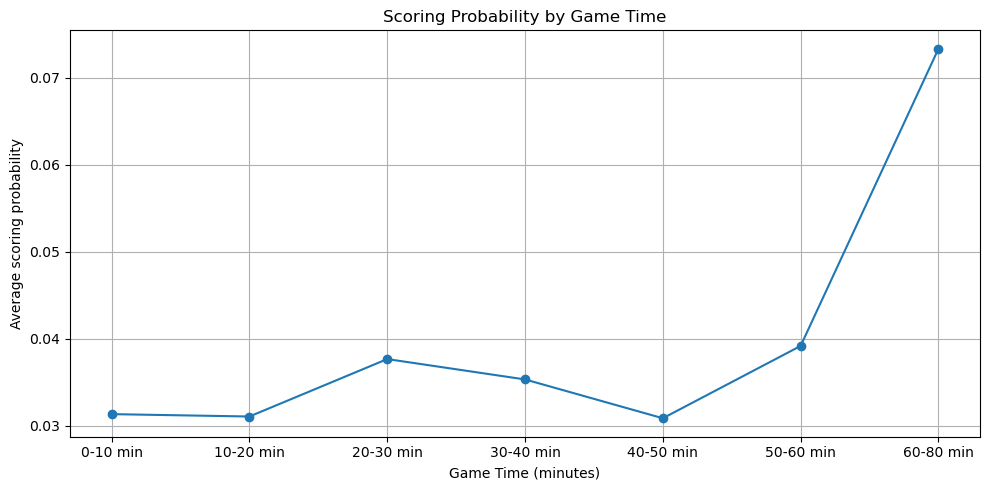

In [ ]:
# Define the ranges
ranges = [(0, 600), (600, 1200), (1200, 1800), (1800, 2400),
          (2400, 3000), (3000, 3600), (3600, 4800)]

# Store results
bin_labels = []
mean_scores = []

# Compute average per bin
for lower, upper in ranges:
    group = vaep_df[(vaep_df['time'] > lower) & (vaep_df['time'] <= upper)]
    mean_value = group['prob_score_after'].mean()
    
    # Save midpoint label and mean
    bin_labels.append(f"{lower//60}-{upper//60} min")
    mean_scores.append(mean_value)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bin_labels, mean_scores, marker='o')
plt.xlabel('Game Time (minutes)')
plt.ylabel('Average scoring probability')
plt.title('Scoring Probability by Game Time')
plt.grid(True)
plt.tight_layout()
plt.show()

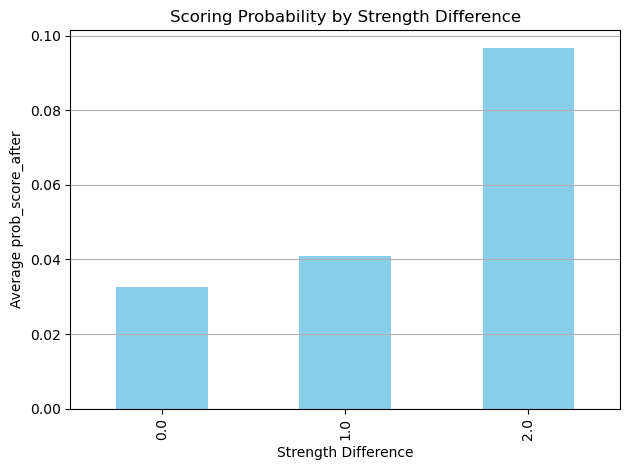

In [ ]:
strength_stats = vaep_df.groupby('strength_difference')['prob_score_after'].mean()
strength_stats.plot(kind='bar', color='skyblue')
plt.xlabel('Strength Difference')
plt.ylabel('Average prob_score_after')
plt.title('Scoring Probability by Strength Difference')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

C:\Users\CasGerritsen\AppData\Local\Temp\ipykernel_11528\3473231920.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_means = vaep_df.groupby('x_bin')[['prob_score_before', 'prob_concede_before']].mean()


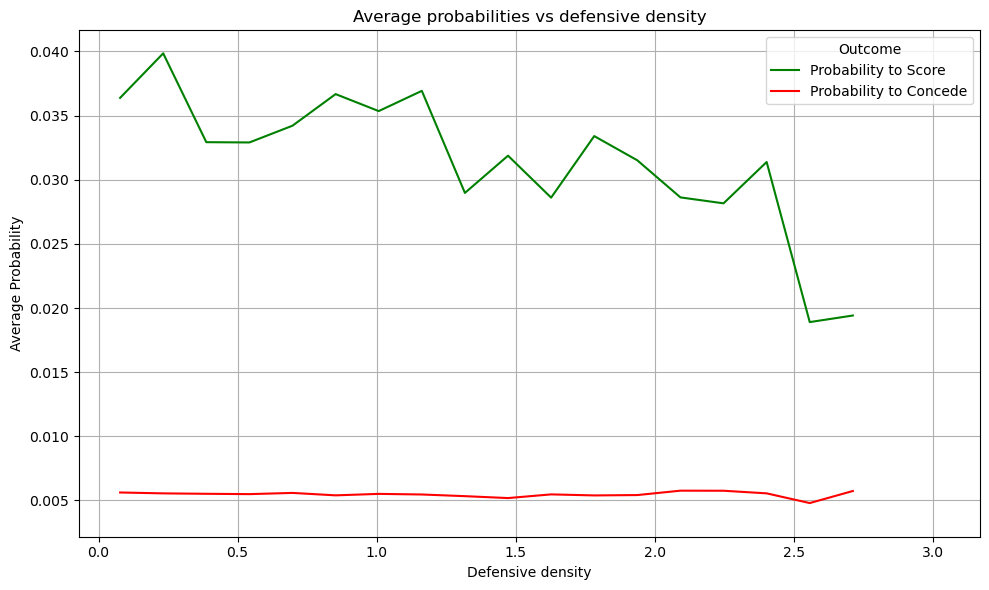

In [ ]:
# Define bins and compute binned means
vaep_df['x_bin'] = pd.cut(vaep_df['defensive_density'], bins=np.linspace(0, 3.1, 21))  # 20 bins

binned_means = vaep_df.groupby('x_bin')[['prob_score_before', 'prob_concede_before']].mean()
binned_centers = [interval.mid for interval in binned_means.index]

plt.figure(figsize=(10, 6))
plt.plot(binned_centers, binned_means['prob_score_before'], label='Probability to Score', color='green')
plt.plot(binned_centers, binned_means['prob_concede_before'], label='Probability to Concede', color='red')

plt.xlabel('Defensive density')
plt.ylabel('Average Probability')
plt.title('Average probabilities vs defensive density')
plt.legend(title='Outcome')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
max_game_id = new_x['game_id'].max()
filtered_df = new_x[new_x['game_id'] == 7]
filtered_df = filtered_df[filtered_df['actiontype_eventshot'] == 1]
successful_actions_id = filtered_df[filtered_df['actionresult_success'] == 1]

In [ ]:
successful_actions_id

,time,start_x_ai,start_z_ai,end_x_ai,end_z_ai,start_dist_to_goal_ai,start_angle_to_angle_ai,end_dist_to_goal_ai,end_angle_to_angle_ai,movement_ai,...,actiontype_eventpass_prev3,actiontype_eventshot_prev3,actiontype_eventturnover_prev3,actionresult_success_prev3,actionresult_miss_prev3,team_prev3,strength_difference_prev3,game_id,timestamp,TimestampUTC
3903,1636.0,22.2485,-2.1173,26.95,0.0,5.156264,-155.755788,0.0,0.0,5.156264,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7,1.729826e+12,1.729826e+12
3979,2104.0,25.1662,0.3170,26.95,0.0,1.811748,-10.076862,0.0,0.0,1.811748,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,7,1.729827e+12,1.729827e+12
4055,2660.0,20.9861,-3.8497,26.95,0.0,7.098471,-147.157740,0.0,0.0,7.098471,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,7,1.729829e+12,1.729829e+12
4140,3060.0,22.9265,1.6546,26.95,0.0,4.350431,-22.354131,0.0,0.0,4.350431,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7,1.729830e+12,1.729830e+12
4205,3397.0,8.5186,-9.5304,26.95,0.0,20.749579,27.342315,0.0,0.0,20.749579,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,7,1.729831e+12,1.729831e+12
4245,4585.0,24.6949,-0.1038,26.95,0.0,2.257488,2.635407,0.0,0.0,2.257488,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,7,1.729832e+12,1.729832e+12


prev3: pass (1223) | start=(12.8148, -11.7749), end=(9.7829, -7.028), dx=-3.0319000000000003, dz=4.746900000000001
prev2: pass (1226) | start=(9.0218, -3.2897), end=(10.2579, -10.2793), dx=1.2360999999999986, dz=-6.989599999999999
prev1: pass (1228) | start=(17.7258, -11.1149), end=(26.461599999999997, -3.4842), dx=8.735799999999998, dz=7.630700000000001
current: pass (1229) | start=(28.2134, -4.3758), end=(18.5853, -3.8531999999999997), dx=-9.6281, dz=0.5226000000000002


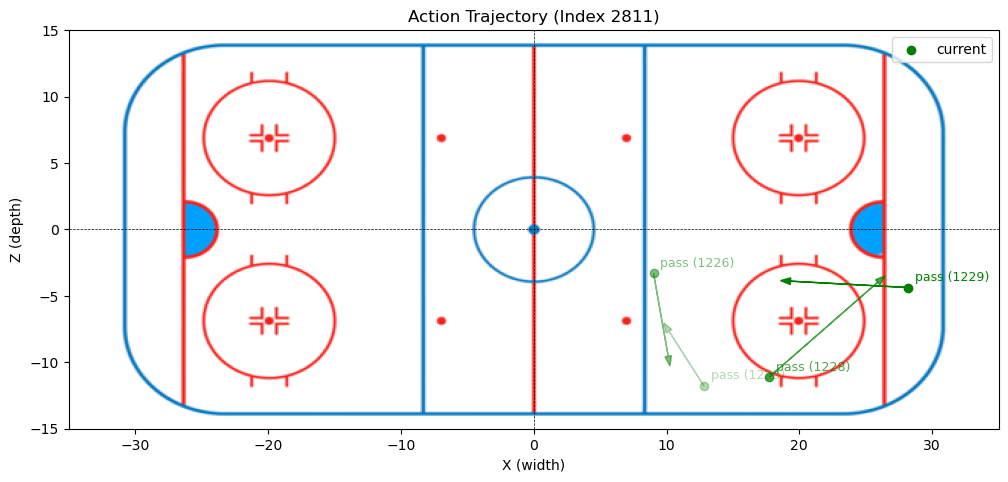

In [ ]:
plot_action_with_history(new_x, 2811)

In [ ]:
for i in range((2811-3), (2811+1)):  # start from one after the first action
    action_prev = new_x.iloc[[i - 1]]
    action_curr = new_x.iloc[[i]]
    
    # Predict probabilities before and after the current action
    prob_score_before = models["scores"].predict_proba(action_prev)[0][1]
    prob_score_after = models["scores"].predict_proba(action_curr)[0][1]

    prob_concede_before = models["concedes"].predict_proba(action_prev)[0][1]
    prob_concede_after = models["concedes"].predict_proba(action_curr)[0][1]
    
    # VAEP calculation
    vaep = (prob_score_after - prob_score_before) - (prob_concede_after - prob_concede_before)
    
    print(f"Action {i} (start_x: {action_curr["start_x_ai"]})")
    print(f"Score Before: {prob_score_before:.4f}, After: {prob_score_after:.4f}")
    print(f"Concede Before: {prob_concede_before:.4f}, After: {prob_concede_after:.4f}")
    print(f"VAEP = {vaep:.4f}")
    print("   ")

Action 2808 (start_x: 2808    12.8148
Name: start_x_ai, dtype: float64)
Score Before: 0.0000, After: 0.0000
Concede Before: 0.0016, After: 0.0007
VAEP = 0.0009
   
Action 2809 (start_x: 2809    9.0218
Name: start_x_ai, dtype: float64)
Score Before: 0.0000, After: 0.0000
Concede Before: 0.0007, After: 0.0008
VAEP = -0.0001
   
Action 2810 (start_x: 2810    17.7258
Name: start_x_ai, dtype: float64)
Score Before: 0.0000, After: 0.0000
Concede Before: 0.0008, After: 0.0004
VAEP = 0.0004
   
Action 2811 (start_x: 2811    28.2134
Name: start_x_ai, dtype: float64)
Score Before: 0.0000, After: 0.0000
Concede Before: 0.0004, After: 0.0004
VAEP = -0.0000
   


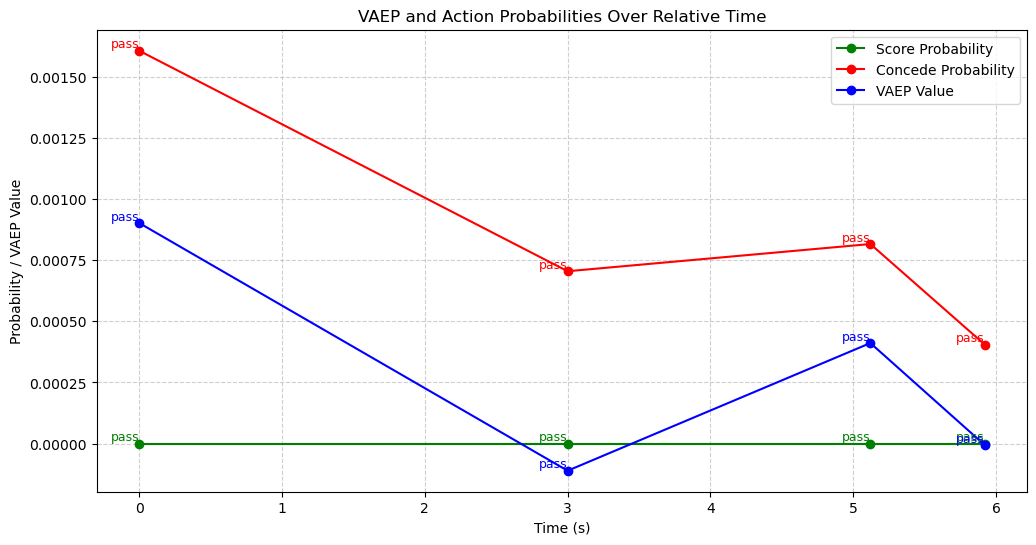

In [ ]:
action_indices = range((2811-3), (2811+1))
vaep_values = []
score_probs = []
concede_probs = []
times = []
labels = []

for i in action_indices:  # start from one after the first action
    action_prev = new_x.iloc[[i - 1]]
    action_curr = new_x.iloc[[i]]
    
    # Extract time for x-axis
    times.append(action_curr['TimestampUTC'].values[0])
    
    # Determine action type (pass or shot)
    action_type = "unknown"
    if action_curr['actiontype_eventpass'].values[0] == 1:
        action_type = "pass"
    elif action_curr['actiontype_eventshot'].values[0] == 1:
        action_type = "shot"
    labels.append(action_type)
    
    # Predict probabilities before and after the current action
    prob_score_before = models['scores'].predict_proba(action_prev)[0][1]
    prob_score_after = models['scores'].predict_proba(action_curr)[0][1]

    prob_concede_before = models['concedes'].predict_proba(action_prev)[0][1]
    prob_concede_after = models['concedes'].predict_proba(action_curr)[0][1]
    
    # VAEP calculation
    vaep = (prob_score_after - prob_score_before) - (prob_concede_after - prob_concede_before)
    vaep_values.append(vaep)
    score_probs.append(prob_score_before)
    concede_probs.append(prob_concede_before)

# Convert to relative time (e.g., seconds)
start_time = min(times)
relative_times = [(t - start_time) / 1000 for t in times]  # Convert to seconds

plt.figure(figsize=(12, 6))
plt.plot(relative_times, score_probs, label='Score Probability', marker='o', color='green')
plt.plot(relative_times, concede_probs, label='Concede Probability', marker='o', color='red')
plt.plot(relative_times, vaep_values, label='VAEP Value', marker='o', color='blue')

# Add labels to each point
for t, s, c, v, lbl in zip(relative_times, score_probs, concede_probs, vaep_values, labels):
    plt.text(t, s, lbl, fontsize=9, color='green', ha='right', va='bottom')
    plt.text(t, c, lbl, fontsize=9, color='red', ha='right', va='bottom')
    plt.text(t, v, lbl, fontsize=9, color='blue', ha='right', va='bottom')

plt.title('VAEP and Action Probabilities Over Relative Time')
plt.xlabel('Time (s)')
plt.ylabel('Probability / VAEP Value')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()